In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [45]:
import pandas as pd

df = pd.read_csv('/content/spam.csv', encoding='latin1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [46]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


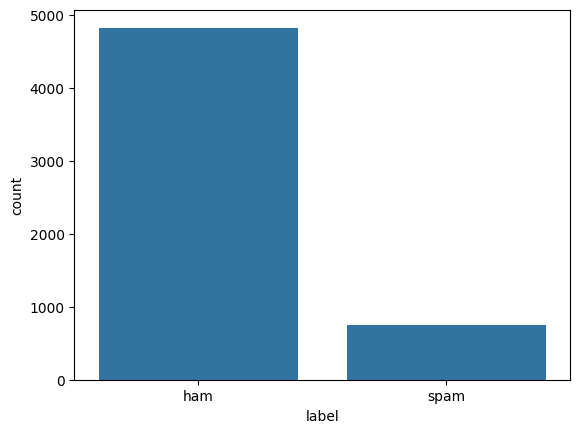

In [48]:
sns.countplot(x=df['label'])
plt.show()


In [49]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [50]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


In [51]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [54]:
nb_accuracy = accuracy_score(y_test,baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



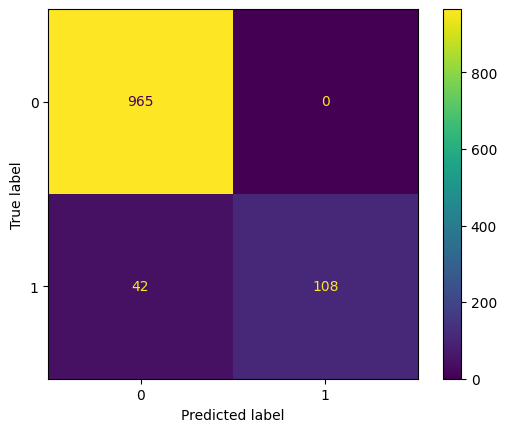

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, baseline_model.predict(X_test_vec))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()




In [60]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [62]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)


In [63]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])


In [65]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,994,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,999,041 (7.63 MB)

 Trainable params: 1,999,041 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
MAXTOKENS = total_words_length
OUTPUTLEN = avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
model_1.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
               metrics=['accuracy'])
history_1 = model_1.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8602 - loss: 0.6249 - val_accuracy: 0.9704 - val_loss: 0.5787
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9862 - loss: 0.5710 - val_accuracy: 0.9794 - val_loss: 0.5740
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9930 - loss: 0.5671 - val_accuracy: 0.9830 - val_loss: 0.5729
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9975 - loss: 0.5646 - val_accuracy: 0.9830 - val_loss: 0.5727
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9977 - loss: 0.5640 - val_accuracy: 0.9812 - val_loss: 0.5723


<Axes: >

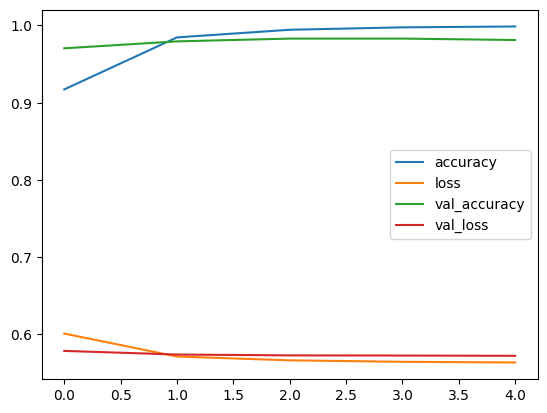

In [85]:
pd.DataFrame(history_1.history).plot()


In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):

	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def evaluate_model(model, X, y):

	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):

  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test))
  else:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history




In [87]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)

X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_test = tf.convert_to_tensor(X_test, dtype=tf.string)

history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.9413 - loss: 0.1852 - val_accuracy: 0.9830 - val_loss: 0.0792
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9987 - loss: 0.0041 - val_accuracy: 0.9785 - val_loss: 0.1009
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9812 - val_loss: 0.0990
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 1.0000 - loss: 9.8316e-05 - val_accuracy: 0.9821 - val_loss: 0.1123
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 1.0000 - loss: 3.3941e-05 - val_accuracy: 0.9830 - val_loss: 0.1179


In [88]:
compile_model(model_2)

X_train = tf.convert_to_tensor(X_train, dtype=tf.string)
X_test = tf.convert_to_tensor(X_test, dtype=tf.string)

history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 1.0000 - loss: 4.4071e-06 - val_accuracy: 0.9830 - val_loss: 0.1899
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 1.0000 - loss: 9.4705e-08 - val_accuracy: 0.9830 - val_loss: 0.2012
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 1.0000 - loss: 3.8263e-08 - val_accuracy: 0.9830 - val_loss: 0.2082
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 1.0000 - loss: 2.6209e-08 - val_accuracy: 0.9830 - val_loss: 0.2130
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 1.0000 - loss: 1.5391e-08 - val_accuracy: 0.9830 - val_loss: 0.2170


In [89]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.optimizer.set_jit(False)

input_layer = keras.Input(shape=[], dtype=tf.string)

use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation=keras.activations.relu)(x)
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

model_3 = keras.Model(input_layer, output_layer)

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)




Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8788 - loss: 0.4243 - val_accuracy: 0.9677 - val_loss: 0.1099
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9768 - loss: 0.0889 - val_accuracy: 0.9758 - val_loss: 0.0704
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9823 - loss: 0.0578 - val_accuracy: 0.9794 - val_loss: 0.0601
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9844 - loss: 0.0492 - val_accuracy: 0.9830 - val_loss: 0.0537
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9865 - loss: 0.0417 - val_accuracy: 0.9830 - val_loss: 0.0514


In [90]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results



35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.978475,0.992188,0.846667,0.913669
Bidirectional-LSTM Model,0.982960,0.964539,0.906667,0.934708
USE-Transfer learning Model,0.982960,0.971223,0.900000,0.934256


<Axes: >

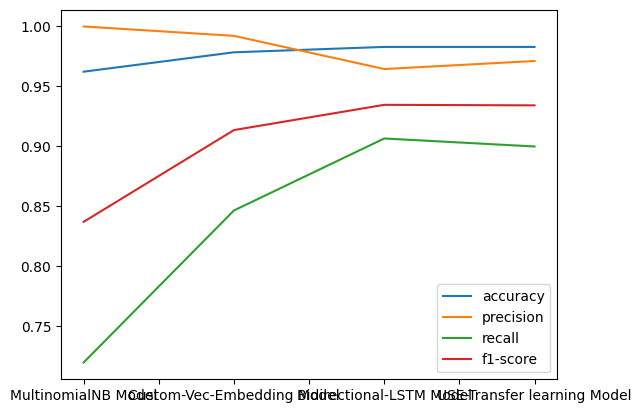

In [92]:
pd.DataFrame(total_results).plot()